In [19]:
import numpy as np
import matplotlib.pyplot as plt
import random
import keras
from keras.datasets import mnist
from keras.layers import *
from keras.models import Model, load_model
from keras.optimizers import Adam


In [2]:
# Global settings. 
BATCH_SIZE = 128
NUM_CLASSES = 10
EPOCHS = 10

%matplotlib inline

## Load and inspect the data
* This loads the MNIST database of handwritten digits. The dataset contains 60000 pcs of 28x28 pixel grayscale images of the 10 digits along with a test set of 10000 images. 
* The dataset is automatically downloaded when running the code for the first time. 
* x_train and x_test are the image arrays for model training and test use. 
* y_train and y_test contain the labels for the images, i.e. what digit value the image represents.  
* All the data is in Numpy array format. 
* Very brief exploratory data analysis is done to check the image distribution to different classes. Few images are plotted to visually check the data and to make observations about the data properties, such as the pixel value range. 

In [3]:
# Load the data. 
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Inspect the array dimensions. 
print('x_train array shape is {} and y_train shape is {}'.format(x_train.shape, y_train.shape))
print('x_test array shape is {} and y_test shape is {}'.format(x_test.shape, y_test.shape))

x_train array shape is (60000, 28, 28) and y_train shape is (60000,)
x_test array shape is (10000, 28, 28) and y_test shape is (10000,)


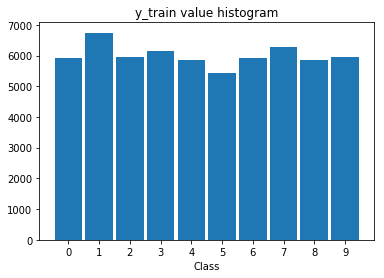

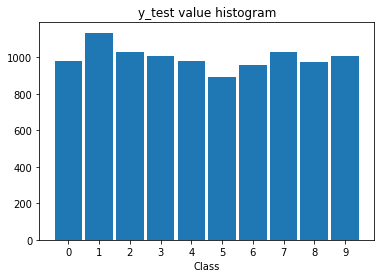

In [4]:
# Plot the label histograms. 
plt.hist(y_train, bins=range(11), rwidth=.9, align='left')
plt.xticks(range(10))
plt.title('y_train value histogram')
plt.xlabel('Class')
plt.show()

plt.hist(y_test, bins=range(11), rwidth=.9, align='left')
plt.xticks(range(10))
plt.title('y_test value histogram')
plt.xlabel('Class')
plt.show()

The histograms look well balanced, i.e. there is roughly equal amount of each digit from 0 to 9. If the classes would be significantly unbalanced, it could be necessary to adjust the sample selections to balance the classes, or use class-specific weighting in the model training. 


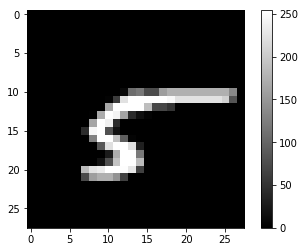

The image label is 5


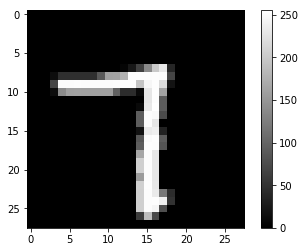

The image label is 7


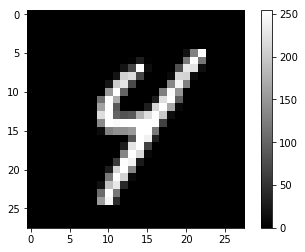

The image label is 4


In [5]:
# Plot some random samples from the training set. 
for i in range(3):
    idx = random.randrange(x_test.shape[0])
    plt.imshow(x_test[idx], cmap='gray')
    plt.colorbar()
    plt.show()
    print('The image label is {}'.format(y_test[idx]))

## Scale the data. 

This is important step, since neural networks are typically used with floating point pixel values in [0, 1] range. Other ranges are also possible, for example [-1, 1] is another popular selection. Original image pixel values are [0, 255] so the scaling can be done by dividing the values by 255. 


In [6]:
# Convert data to floating point.
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

# Scale the values. 
x_train /= 255
x_test /= 255

## Adjust the image array dimensions. 
Keras with Tensorflow backend expects the image array always in shape (img_number, img_rows, img_columns, img_color_channels). That is used in this program. The original data comes without the separate dimension for image color channel (which is possible with grayscale images), so we must add the dimension to the arrays. 

In [7]:
# Mofify the array dimensions.
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]
print('x_train array shape is {} and x_test shape is {}'.format(x_train.shape, x_test.shape))

x_train array shape is (60000, 28, 28, 1) and x_test shape is (10000, 28, 28, 1)


## One-hot encode the label vectors
In classification tasks the data labels are very often encoded in one-hot format. 
For example, label 6 is encoded as [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
The neural network uses this same format to output the prediction results. 

In [8]:
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Print sample from training data labels. 
index = 42
print(y_train[index])
print('The above data label is {}.'.format(np.argmax(y_train[index])))

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
The above data label is 7.


## Setup the neural network model
This model can achieve approx. 99.2% accuracy after 10 training epochs. One epoch takes 65 second computing time on 3 GHz i5 laptop, so this model is suitable for CPU training. On a GFX1080TI GPU the training takes 6 seconds per epoch. This model architecture is result of many experiments and this model is heavily optimized for simplicity, low parameter count and fast computing without sacrificing accuracy. There are some features to highlight: 
* This model architecture follows the typical image classification CNN architecture, in which there are few convolutional layers followed by maxpooling, and that structure is repeated multiple times. The convolutional layers extract elementary features of the images. After the last maxpooling layer the 3D feature array is flattened to 1D vector, which is then connected to dense layers. The purpose of the dense layers is to use the elementary image feature information from convolutional layers and combine individual features so that it can perform the classification task.
* Only a small number of convolutional filters is used at layer_1 that operates at input image resolution. It helps to speed up the processing, since convolutions take lot of processing time. From the above image samples it can be seen that the digits are scanned at quite high resolution, so we can estimate that most of the processing can be done at lower resolution. 
* Most of the computing happens on layers 3 to 6, which operate at half of the original image resolution. The stack of three 32 filter layers + one 8 filter layer is result of experimentation. Very likely most of the image feature detection happens on those three 32 filter layers and the 8 filter layer (layer_6) only summarizes the results. 
* The last convolutional layer (layer_6) is very small, only 8 filters. This results in  small parameter count when the output is maxpooled (resolution is reduced to half), flattened and connected with the dense layer (layer_10). Thus the dense layer has only 7 x 7 x 8 x 128 = ~50k parameters, which is two thirds of the total model parameters. Dense layers are fast to compute, so the 50k parameters are not going to be a performance problem. 
* The convolutional layers use the very typical 3 x 3 filter size. 
* The 25% dropout (at training time) on layer 9 is important for model accuracy. It helps the model to generalize the learnings and prevents it from learning the training images too well (overfitting). 
* The dense layer (layer_10) contains 128 nodes that is quite small amount. The node amount was defined by experimentation and 128 works very well, since the MNIST is simple classification problem. 
* The final dense layer (outputs) node count must match to the number of image classes, which is 10 in this example. 
* This model definition uses Keras functional API https://keras.io/getting-started/functional-api-guide/ which is most suitable for professional applications, since it is very flexible and allows lot of freedom in the model layer configurations. 

In [9]:
def get_model(): 
    input_size = (28, 28, 1) # image rows, columns, color channels. 
    
    # Model layers
    inputs = Input(input_size, name='inputs')
    layer_1 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='layer_1')(inputs)
    layer_2 = MaxPooling2D(pool_size=(2, 2), name='layer_2')(layer_1)
    
    layer_3 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='layer_3')(layer_2)
    layer_4 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='layer_4')(layer_3)
    layer_5 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='layer_5')(layer_4)
    layer_6 = Conv2D(8, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', name='layer_6')(layer_5)
    layer_7 = MaxPooling2D(pool_size=(2, 2), name='layer_7')(layer_6)
    
    layer_8 = Flatten(name='layer_8')(layer_7)
    layer_9 = Dropout(0.25, name='layer_9')(layer_8)
    layer_10 = Dense(128, activation='relu', name='layer_10')(layer_9)
    outputs = Dense(NUM_CLASSES, activation='softmax', name='outputs')(layer_10)    
    
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Get the model.
model = get_model()

# Print model summary.
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_1 (Conv2D)             (None, 28, 28, 8)         80        
_________________________________________________________________
layer_2 (MaxPooling2D)       (None, 14, 14, 8)         0         
_________________________________________________________________
layer_3 (Conv2D)             (None, 14, 14, 32)        2336      
_________________________________________________________________
layer_4 (Conv2D)             (None, 14, 14, 32)        9248      
_________________________________________________________________
layer_5 (Conv2D)             (None, 14, 14, 32)        9248      
_________________________________________________________________
layer_6 (Conv2D)             (None, 14, 14, 8)         2312      
__________

## Train the model 
This is the phase where the model is trained using the training data (x_train, y_train) and the accuracy is tested using testing data (x_test, y_test). Model training is done by calling the model.fit method.

The model learns only from the training data. The testing data is used only to monitor the training process, and model learning is disabled when the testing data is shown to the model. 

The model.fit method returns training history data that can be later visualized. 

### Epochs and batches
Training is performed in epochs. Epoch means that all training data is presented to the model once during the epoch. At the end of the epoch the testing data is used to calculate the model accuracy. 

The epoch is split into batches to simplify the processing work. In this program the batch size is 128, which means that 128 images are shown to the model at a time. In Keras framework the model learning is averaged over the batch, i.e. the model makes predictions for all images in the batch, the prediction errors are calculated by the loss function, and the loss function result is used to guide the model training. 

Batch size is very important hyperparameter to optimize and it is often done by experimentation. Some rough guidelines can be mentioned:
* Smaller batch size means slower training process, since all the processing happens in smaller parts and moving the data around takes more time. In some cases small batch size can improve model accuracy. Smaller batch size will also reduce the amount of memory needed for the training process. For example, with very large models and large images the batch size could be in range from 1 to 16 only because of memory limitations (typically 11 GB memory on GPUs). 
* Larger batch size often speeds up the training processing, but after certain point (to be found by experimentation) the model accuracy starts to decrease. 

### Model optimizer and learning rate
A very important topic is the model optimizer and the learning rate. It was defined above in the model setup in the model compile phase by specifying "Adam(lr=0.001)". Adam is very common optimizer algorithm and good choice for generic models like this. Here the learning rate is set to 0.001, which is also very common value. A larger value would train the model faster, but it could become less accurate. A smaller learning rate could result in more accurate model, but the training would take longer time. Often additional decay parameter is specified so that the training can start at large learning rate and the learning rate reduces during the training so that it results in fast and accurate model training, but it can take lot of effort to find a good learning rate and decay combination. 

### Training performance indicators
The model.fit process prints lot of data during the training, of which the following are most important: 
* loss: This is the loss function (categorical crossentropy) value during the training. The loss functions are defined so that the value decreases when the model accuracy increases. This guides the model learning, e.g., if the loss value increases, the model has learned something wrong and has to correct it. 
* acc: This is the model accuracy that is calculated during the training. This is very informative for following the training process. The values are in 0 to 1 range, and 0.0 means 0% accuracy and 1.0 means 100% accuracy. 
* val_loss: This is basically same as the loss described above, but val_loss is calculated from the testing data set at the end of each epoch. It is not used for the model training, i.e. it is only informative data. 
* val_acc: This is the model accuracy calculated using the testing data. This is often the most important parameter to follow, since it tells that how accurately the model performs in predicting the image labels. 

In [10]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.2577 - acc: 0.9171 - val_loss: 0.0677 - val_acc: 0.9785
Epoch 2/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0827 - acc: 0.9749 - val_loss: 0.0438 - val_acc: 0.9854
Epoch 3/10
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0612 - acc: 0.9805 - val_loss: 0.0384 - val_acc: 0.9870
Epoch 4/10
60000/60000 [==============================] - 82s 1ms/step - loss: 0.0521 - acc: 0.9835 - val_loss: 0.0334 - val_acc: 0.9887
Epoch 5/10
60000/60000 [==============================] - 81s 1ms/step - loss: 0.0426 - acc: 0.9863 - val_loss: 0.0276 - val_acc: 0.9901
Epoch 6/10
60000/60000 [==============================] - 67s 1ms/step - loss: 0.0391 - acc: 0.9875 - val_loss: 0.0268 - val_acc: 0.9914
Epoch 7/10
60000/60000 [==============================] - 64s 1ms/step - loss: 0.0341 - acc: 0.9888 - val_loss: 0.0271 - val_acc

## Plot the training history

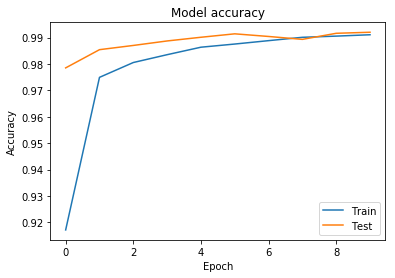

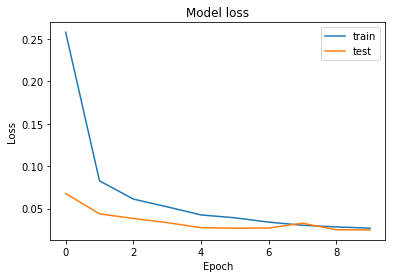

In [12]:
# Accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

# Loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

## Save the model to file
This saves the trained model to .h5 file that can be used in model deployment. 

In [13]:
filename = 'MNIST_model.h5'
model.save(filename)

## Load the model from file and make some predictions

In [14]:
# Load the model.
filename = 'MNIST_model.h5'
model = load_model(filename)

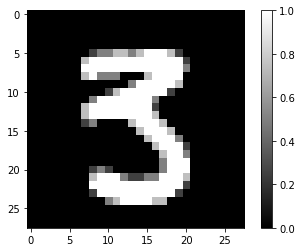

The image label is 3
The model prediction is 3


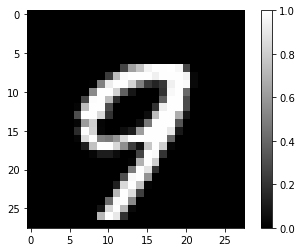

The image label is 9
The model prediction is 9


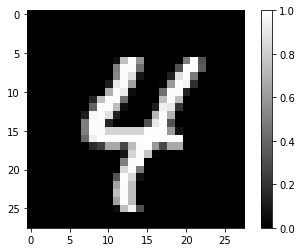

The image label is 4
The model prediction is 4


In [15]:
# Make predictions. 
for i in range(3):
    # Get random image index. 
    idx = random.randrange(x_test.shape[0])
    
    # Plot image. 
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.colorbar()
    plt.show()
    
    # Run the model inference to get predicted label and print the results. 
    prediction = model.predict(np.expand_dims(x_test[idx], axis=0))
    print('The image label is {}'.format(np.argmax(y_test[idx])))
    print('The model prediction is {}'.format(np.argmax(prediction)))

## Plot example where the model prediction fails

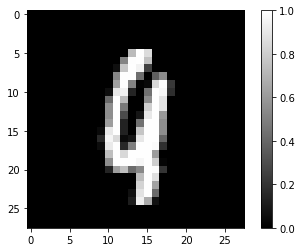

Prediction was 4 but the real label is 9


In [18]:
while True: # The model will never achieve 100% accuracy, so while True loop is safe to use. 
    idx = random.randrange(x_test.shape[0])   
    prediction = np.argmax(model.predict(np.expand_dims(x_test[idx], axis=0)))
    ground_truth = np.argmax(y_test[idx])
    if prediction != ground_truth:
        break
    
# Plot image. 
plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()
print('Prediction was {} but the real label is {}'.format(prediction, ground_truth))